## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
#資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

#Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

#Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 #IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.5]
redice_lr_patient = [10, 20]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 10
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_____________________________________________________________

49/49 [==============================] - 1s 29ms/step - loss: 1.2651 - accuracy: 0.5578 - val_loss: 1.4805 - val_accuracy: 0.4759
Epoch 14/25
49/49 [==============================] - 1s 29ms/step - loss: 1.2449 - accuracy: 0.5647 - val_loss: 1.4719 - val_accuracy: 0.4839
Epoch 15/25
49/49 [==============================] - 2s 32ms/step - loss: 1.2242 - accuracy: 0.5731 - val_loss: 1.4648 - val_accuracy: 0.4866
Epoch 16/25
49/49 [==============================] - 2s 39ms/step - loss: 1.2034 - accuracy: 0.5814 - val_loss: 1.4566 - val_accuracy: 0.4916
Epoch 17/25
49/49 [==============================] - 2s 44ms/step - loss: 1.1826 - accuracy: 0.5898 - val_loss: 1.4606 - val_accuracy: 0.4864
Epoch 18/25
49/49 [==============================] - 3s 64ms/step - loss: 1.1662 - accuracy: 0.5964 - val_loss: 1.4556 - val_accuracy: 0.4939
Epoch 19/25
49/49 [==============================] - 4s 88ms/step - loss: 1.1468 - accuracy: 0.6025 - val_loss: 1.4570 - val_accuracy: 0.4929
Epoch 20/25
49/49 

Epoch 1/25
49/49 [==============================] - 2s 42ms/step - loss: 2.2243 - accuracy: 0.2723 - val_loss: 2.1159 - val_accuracy: 0.2229
Epoch 2/25
49/49 [==============================] - 2s 37ms/step - loss: 1.7596 - accuracy: 0.3887 - val_loss: 1.9804 - val_accuracy: 0.2852
Epoch 3/25
49/49 [==============================] - 2s 31ms/step - loss: 1.6315 - accuracy: 0.4297 - val_loss: 1.8289 - val_accuracy: 0.3617
Epoch 4/25
49/49 [==============================] - 1s 30ms/step - loss: 1.5558 - accuracy: 0.4543 - val_loss: 1.7258 - val_accuracy: 0.3903
Epoch 5/25
49/49 [==============================] - 1s 30ms/step - loss: 1.5013 - accuracy: 0.4729 - val_loss: 1.6306 - val_accuracy: 0.4307
Epoch 6/25
49/49 [==============================] - 1s 30ms/step - loss: 1.4560 - accuracy: 0.4859 - val_loss: 1.5793 - val_accuracy: 0.4469
Epoch 7/25
49/49 [==============================] - 2s 31ms/step - loss: 1.4192 - accuracy: 0.5016 - val_loss: 1.5390 - val_accuracy: 0.4616
Epoch 8/25
49

49/49 [==============================] - 2s 35ms/step - loss: 0.5799 - accuracy: 0.8184 - val_loss: 1.4017 - val_accuracy: 0.5361
Epoch 23/25
49/49 [==============================] - 2s 36ms/step - loss: 0.5716 - accuracy: 0.8219 - val_loss: 1.3995 - val_accuracy: 0.5397
Epoch 24/25
49/49 [==============================] - 2s 38ms/step - loss: 0.5593 - accuracy: 0.8269 - val_loss: 1.4039 - val_accuracy: 0.5357
Epoch 25/25
49/49 [==============================] - ETA: 0s - loss: 0.5508 - accuracy: 0.8316
Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
49/49 [==============================] - 2s 39ms/step - loss: 0.5508 - accuracy: 0.8316 - val_loss: 1.4100 - val_accuracy: 0.5392
Numbers of exp: 5, reduce_factor: 0.10, reduce_patient: 20
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3072)]            0         


Epoch 8/25
49/49 [==============================] - 2s 35ms/step - loss: 1.5756 - accuracy: 0.4494 - val_loss: 1.6439 - val_accuracy: 0.4198
Epoch 9/25
49/49 [==============================] - 2s 36ms/step - loss: 1.5533 - accuracy: 0.4555 - val_loss: 1.6316 - val_accuracy: 0.4233
Epoch 10/25
49/49 [==============================] - 2s 34ms/step - loss: 1.5342 - accuracy: 0.4623 - val_loss: 1.6193 - val_accuracy: 0.4269
Epoch 11/25
49/49 [==============================] - 2s 33ms/step - loss: 1.5174 - accuracy: 0.4685 - val_loss: 1.6117 - val_accuracy: 0.4304
Epoch 12/25
49/49 [==============================] - 2s 32ms/step - loss: 1.5011 - accuracy: 0.4757 - val_loss: 1.6104 - val_accuracy: 0.4344
Epoch 13/25
49/49 [==============================] - 2s 31ms/step - loss: 1.4862 - accuracy: 0.4798 - val_loss: 1.6003 - val_accuracy: 0.4377
Epoch 14/25
49/49 [==============================] - 2s 32ms/step - loss: 1.4724 - accuracy: 0.4856 - val_loss: 1.5988 - val_accuracy: 0.4386
Epoch 15

Epoch 1/25
49/49 [==============================] - 2s 44ms/step - loss: 1.8394 - accuracy: 0.3678 - val_loss: 2.4437 - val_accuracy: 0.2112
Epoch 2/25
49/49 [==============================] - 1s 30ms/step - loss: 1.5415 - accuracy: 0.4562 - val_loss: 2.0130 - val_accuracy: 0.2674
Epoch 3/25
49/49 [==============================] - 1s 30ms/step - loss: 1.4286 - accuracy: 0.4962 - val_loss: 1.8956 - val_accuracy: 0.3136
Epoch 4/25
49/49 [==============================] - 2s 32ms/step - loss: 1.3482 - accuracy: 0.5226 - val_loss: 1.9434 - val_accuracy: 0.3356
Epoch 5/25
49/49 [==============================] - 2s 39ms/step - loss: 1.2889 - accuracy: 0.5454 - val_loss: 1.9536 - val_accuracy: 0.3243
Epoch 6/25
49/49 [==============================] - 2s 39ms/step - loss: 1.2300 - accuracy: 0.5669 - val_loss: 1.8601 - val_accuracy: 0.3526
Epoch 7/25
49/49 [==============================] - 2s 36ms/step - loss: 1.1851 - accuracy: 0.5815 - val_loss: 1.6555 - val_accuracy: 0.4194
Epoch 8/25
49

49/49 [==============================] - 2s 34ms/step - loss: 0.9267 - accuracy: 0.6902 - val_loss: 1.5006 - val_accuracy: 0.4796
Epoch 23/25
49/49 [==============================] - 2s 34ms/step - loss: 0.9061 - accuracy: 0.6979 - val_loss: 1.5836 - val_accuracy: 0.4577
Epoch 24/25
49/49 [==============================] - 2s 33ms/step - loss: 0.8879 - accuracy: 0.7038 - val_loss: 1.5238 - val_accuracy: 0.4800
Epoch 25/25
49/49 [==============================] - 2s 33ms/step - loss: 0.8693 - accuracy: 0.7123 - val_loss: 1.5175 - val_accuracy: 0.4858
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 10
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_______________________________

49/49 [==============================] - 2s 34ms/step - loss: 1.2476 - accuracy: 0.5675 - val_loss: 1.5149 - val_accuracy: 0.4624
Epoch 10/25
49/49 [==============================] - 2s 33ms/step - loss: 1.2173 - accuracy: 0.5798 - val_loss: 1.5061 - val_accuracy: 0.4749
Epoch 11/25
49/49 [==============================] - 2s 33ms/step - loss: 1.1865 - accuracy: 0.5912 - val_loss: 1.5948 - val_accuracy: 0.4431
Epoch 12/25
49/49 [==============================] - 2s 33ms/step - loss: 1.1576 - accuracy: 0.5983 - val_loss: 1.4842 - val_accuracy: 0.4828
Epoch 13/25
49/49 [==============================] - 2s 35ms/step - loss: 1.1313 - accuracy: 0.6098 - val_loss: 1.4894 - val_accuracy: 0.4749
Epoch 14/25
49/49 [==============================] - 2s 33ms/step - loss: 1.1061 - accuracy: 0.6203 - val_loss: 1.5061 - val_accuracy: 0.4746
Epoch 15/25
49/49 [==============================] - 2s 34ms/step - loss: 1.0817 - accuracy: 0.6285 - val_loss: 1.4999 - val_accuracy: 0.4748
Epoch 16/25
49/49 

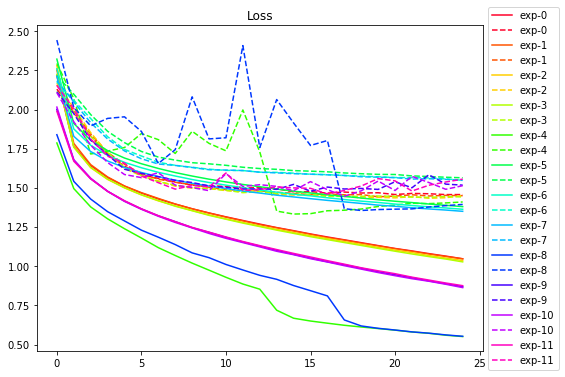

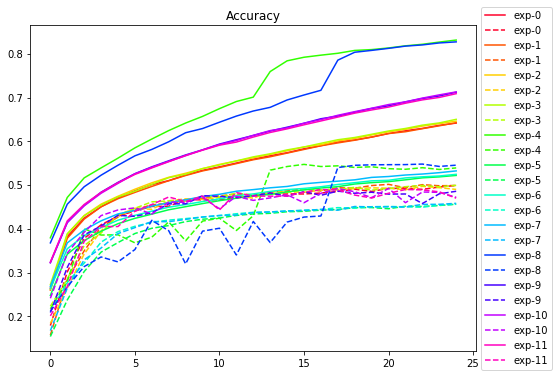

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()